[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eagalpern/folding-ising-globular/blob/master/run_ising_model.ipynb)


In [1]:
import pandas as pd
from matplotlib import pyplot as plt, colors
import numpy as np
import os

import pickle
import sys
import seaborn as sns
import json

In [2]:
sys.path.append('../source/')
from fasta_utils import *
from visualization import *
from plot_results import *
from ising_simulation import *
from utils import *

In [3]:
path ='/home/ezequiel/libraries/folding-ising-globular/'
tsel_fam = pd.read_csv(path+'data/table_s1.csv', index_col =0)
tsel_fam['foldon_breaks']= tsel_fam.foldon_breaks.apply(lambda x: np.array(json.loads(x)))
# esta no tiene el nombre de los MSA ni las carpetas, usar con la version simplificada

In [4]:
i = 7
family = tsel_fam.family[i]
family

'Flavodoxin_1'

In [5]:


# loading from my google drive for now
potts_path = '/home/ezequiel/Deposit/ising_rbm/simplified_rbm_and_msa/'
# potts model
# potts['h'] local field
# potts['J'] couplings

potts = np.load(potts_path+family+'/potts.npz')
fasta_file = get_fasta_file(potts_path+family)
fastapath = potts_path+family+'/'+fasta_file

In [6]:
# family

In [7]:
# Sequence
uniprot_id = tsel_fam.target_seq[i].split('.')[0]
seq_=extract_sequence_from_fasta(uniprot_id,fastapath)
seq=np.array([np.char.upper(x) for x in seq_])
seq_len = len(seq)

In [8]:
# Selection Temperature
Tsel = tsel_fam.Tsel[i]

In [9]:
# Foldon breaks
breaks = tsel_fam.foldon_breaks[i]

In [10]:
# PDB
path_pdb = path + 'data/pdb_files/'
pdb_code = tsel_fam.pdb_code[i]
ali_seq_num_pdb = np.arange(tsel_fam.pdb_ali_beg[i], tsel_fam.pdb_ali_end[i]+1)

In [11]:
# DSSP data
path_dssp = path+'data/dssp/'
dssp_data = pd.read_csv(path_dssp+pdb_code+'.csv')
positions =~np.isnan(dssp_data.exon_freq)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

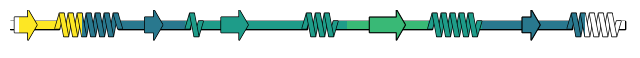

CPU times: user 1.42 s, sys: 308 ms, total: 1.73 s
Wall time: 34.9 s


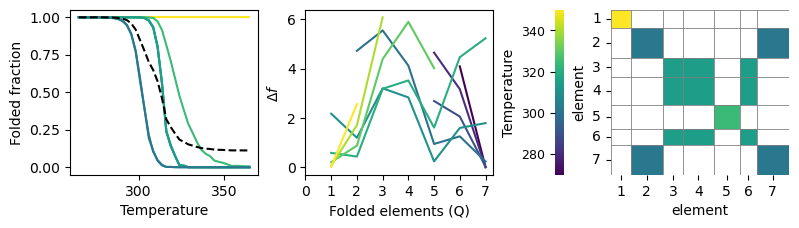

In [12]:
%%time

simulation = True
plot_dssp = True
view3d = True
plot_results = True

output_dir = '/home/ezequiel/Deposit/ising_rbm/tests/'
create_folder(output_dir)

prot_name = 'reference_seq'
vmin= 270
vmax = 350


if simulation:
    features = ising_simulation(potts,
                               breaks,
                               output_dir,
                               seq=seq,
                               prot_name = prot_name,
                               Tsel = Tsel,
                               si0=0.005, # same as in ank paper
                               k=0.001985875, # [kcal /(mol K)]
                               tini_=vmin,
                               tfin_=vmax,
                               DT=10,
                               cp_factor=20,
                               interactions_off=False)
                            #cp_factor=5000) # MC  # changed this from 20 for 3,9,10

if view3d:
    t_ = load_features(output_dir+prot_name+'/')['t_']

    #with open(output_dir+prot_name+'/features.pkl', "rb") as f:  
    #            features = pickle.load(f)

    

    pdb_file= path_pdb+pdb_code+'_cleaned.pdb'


    temps_seq_ref, colors_seq_ref =map_t_seq_3d(t_,
                                              breaks,
                                              seq_len,
                                              rgb=True,
                                              vmin=vmin, 
                                              vmax=vmax)


    view=view_3d_exon_hist(ali_seq_num_pdb,[rgb2hex(c) for c in colors_seq_ref/255],
                           pdb_file)
    view.show()


if plot_dssp:

    
    temps_seq_ref, colors_seq_ref =map_t_seq_3d(t_,
                                              breaks,
                                              seq_len,
                                              rgb=True,
                                              vmin=vmin, 
                                              vmax=vmax)
    
    fig,ax = plt.subplots(1,figsize=(8,0.5))
    colors_pdb = np.array([[255.0,255.0,255.0]]*len(positions))
    colors_pdb [positions] = colors_seq_ref 
    plot_ss_(dssp_data,colors_pdb / 255.0, ax)
    ax.set_axis_off()
    #ax.set_title(family)
    plt.show()

if plot_results:
    fig, ax = build_axes_2(1, 20,5.5)
    ax_ff = ax[0]
    ax_domains_and_fe = [ax[1],ax[2],ax[3]]
    colors_d = plot_ising(output_dir,
               ax_ff,
               ax_domains_and_fe,
               prot_name = prot_name,           
               vmin = vmin, # que coincidan con los de la simualcion?
               vmax = vmax,
               lw=.6, # line width domains 
               lw_fq = 1.5, # line width df
               alpha_fq= 1,# alpha df
               inter_t = 1,# integer,  temperature interval for df
               fontsize = 10,
               noninf = False,
               t0 = 50) # si los limites estan bien puestos es al pedo esto 